# Using Machine-Learning to Predict Stellar Parameters

## Sreevani Jarugula, Colin Burke, Breanna Lucero
### ASTR 596: Fundamentals of Data Science


# Original Implementation

"A Machine-Learning Method to Infer Fundamental Stellar Parameters from Photometric Light Curves" (A. A. Miller, et. al. 2015)

- employed random forest algorithm to perform a non-parametric regression that predicts $T_{eff}$, log g, and [Fe/H] using photometric time-domain observations
- benefit: this framework will allow fundamental parameters to be determined without the need for additional spectroscopy

# The Parameters

## Effective Temperature
- well established that photometric colrs are particularly useful for estimating $T_{eff}$

## Metallicity
- stellar atmospheres with enhanced metal content produce less flux in blue region of the optical
- can leverage this fact to photometrically estimate [Fe/H] using broadband, blue photometric colors

## Surface Gravity
- stellar brightness variations on the timescales of several hours arise from granulation, which in turn, correlates with surface gravity g
- requires high-quality ($\sim$ 0.01 mmag precision), high-cadence (every 30 min) monitoring from space based telescopes


# Features

## Colors
- u - g, g - r, r - i, i - z

## Light curve (LC)

## Colors + LC

# Teff and g  

a) From data  

b) Heiter et al. 2015; FGK stars from Gaia - g is found to decrease with increasing Teff in FGK Giants (upward brach in the plot)

<img src="./logg_Teff_allZ.png" width="400">  <img src="./Heiter_2015.png" width="300">

# HR Diagram 

<img src="./HR_diagram.png" width="400">

# Survey & Training Set

- SDSS Stripe 82: an equatorial, $\sim$ 315 deg$^2$ field
    - repeated scans for each of the ugriz filters
    - includes $\sim$ 9000 spectra
    - stellar parameters measures using SEGUE Stellar Parameters Pipeline (SSPP)
- University of Washington variable source catalog (UWVSC)
    - used as the basis for spectroscopic survey of variability

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LogNorm
from sklearn.metrics import mean_squared_error
from matplotlib.ticker import AutoMinorLocator

from mpl_toolkits.mplot3d import axes3d
#%matplotlib widget
import eli5
from eli5.sklearn import PermutationImportance
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

/Users/sreevani/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/sreevani/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [4]:
df_photo = pd.read_csv('../data/stripe82candidateVar_v1.1.dat',skiprows=5, header=1,index_col=0,sep='\s+')

colnames = ['ID','Priority','Flags','Teff','eTeff','NTeff','logg','elogg','Nlogg','Z','eZ','NZ']
df_spec = pd.read_csv('../data/t3.txt',sep='\s+',skiprows=26,header=None,index_col=0,names=colnames)

#Combine both datasets 
df = pd.merge(df_spec, df_photo, on='ID',how='left')

In [5]:
df_nonan = df[(df['Teff'] != -9999.0) & (df['logg'] != -9999.0) & (df['Z'] != -9999.0)]

# The Model - Neural Net


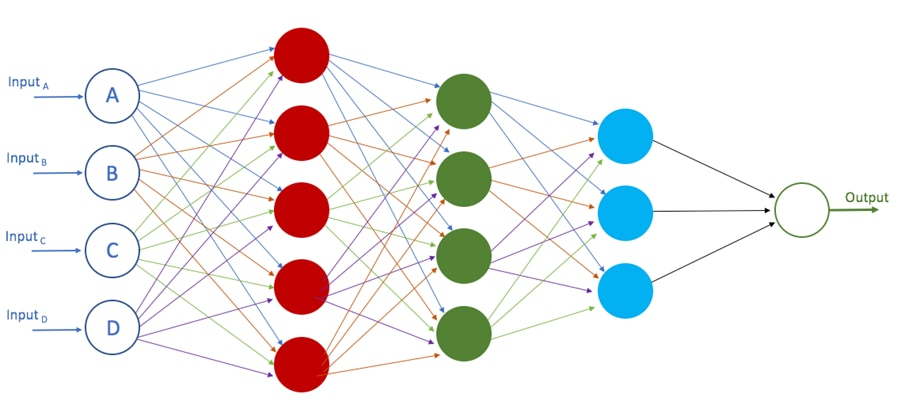

- characterized by multiple "layers"
    - input layer (colors and light curve information)
    - hidden layers
    - output layer ($T_{eff}$, log g, Z)
- hidden layer configuration options
    - how many hidden layers?
    - how many nodes in each hidden layer?
    - define an activation function (randomly assigned weight for each input and bias level for each node)
    - number of iterations & desired error level (training stops at specified value)

In [6]:
def predict(feats, parameter, epochs=100, test_size=0.25, val_split=0.15, loss_fn='mse'):
    '''
    Train NN and plot predictions for parameter ('Teff','Z','logg') using features.
    '''
        
    # Clean data
    df_nonan = df[df[parameter] != -9999.0]
    df_Y = df_nonan[parameter]
    df_X = df_nonan[feats]
    # Split into test and training set
    train_X, test_X, train_y, test_y = train_test_split(df_X, df_Y, random_state=1, test_size=test_size)
    # Print training statistics
    train_stats = train_X.describe()
    train_stats = train_stats.transpose()
    print(train_stats)
    # Normalize data
    train_X_norm = (train_X - train_stats['mean']) / train_stats['std']
    test_X_norm = (test_X - train_stats['mean']) / train_stats['std']
    
    # Model
    model = keras.Sequential([
    keras.layers.Flatten(input_shape=(len(train_X.columns),)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(64, activation=tf.nn.relu),
    #keras.layers.Dropout(0.1),
    keras.layers.Dense(32, activation=tf.nn.relu),
    keras.layers.Dense(1)
    ])
    
    # Optimize and train
    adm = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer='adam', loss=loss_fn,
              metrics=['mae', 'mse','msle','mape','kullback_leibler_divergence'])
    
    # Get training history
    print('Training with %d epochs' % epochs)
    history = model.fit(train_X_norm, train_y, epochs=epochs, batch_size=32, validation_split=val_split, verbose=0)
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    #model_temp.evaluate(test_X_norm, test_y)
    
    # Plot loss curve
    fig = plt.figure(1,figsize=(8,6))
    plt.plot(hist['epoch'],hist['val_loss'], lw=5, label='validation loss')
    plt.plot(hist['epoch'],hist['loss'], lw=3, label='training loss', linestyle='dashed')
    plt.legend(fontsize=20)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.savefig('color-losscurve')
    plt.show()
    # Plot prediction
    test_predictions = model.predict(test_X_norm).flatten()
    t_y = test_y.to_numpy()

    rmse = np.sqrt(mean_squared_error(test_y,test_predictions))
    error = 100*np.abs((t_y-test_predictions)/t_y)
    x = np.arange(np.min(test_predictions),np.max(test_predictions),0.1)
    fig = plt.figure(1,figsize=(8,6))
    plt.scatter(test_y, test_predictions,c=error,cmap='viridis', s=10)
    plt.plot(x,x,'r-')
    plt.plot()
    plt.xlabel('True Values', fontsize=14)
    plt.ylabel('Predictions', fontsize=14)
    plt.xlim(np.min(test_predictions),np.max(test_predictions))
    plt.ylim(np.min(test_predictions),np.max(test_predictions))
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('% Error', fontsize=14)
    plt.text(0.5,0.2,'RMSE=%0.3f'%rmse,transform=plt.gca().transAxes,fontsize=20)
    plt.savefig('color-pred')
    plt.show()

# Colors-only Estimates

Four features used 

It is known that Teff can be very well estimated using photometric colors with respect to spectroscopy, even with a single photomety color (Ivezic et al. 2008a)

We use two architectures to predict Teff, g and Z

1.) Predict each parameter independently 

2.) Predict all the parameters together (to account for correlations) 

### Loss Curves
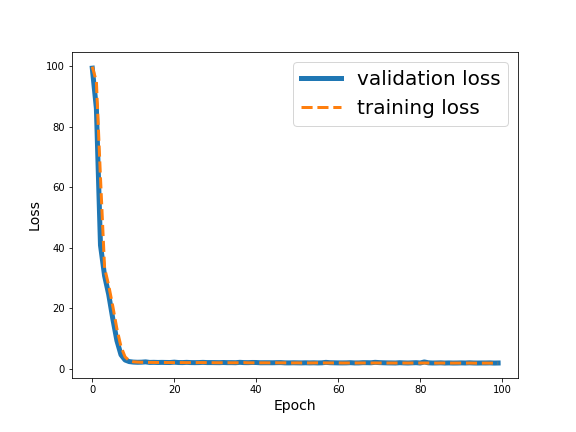


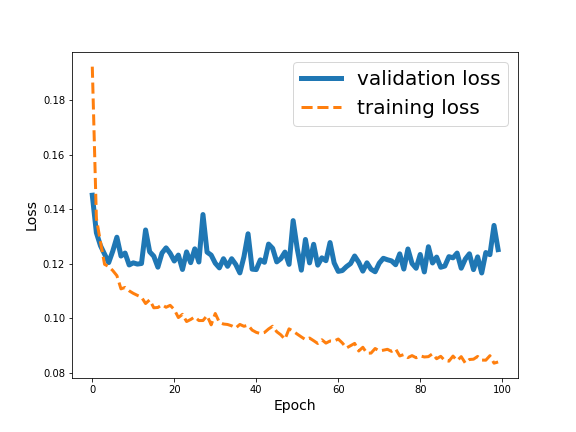

### $\rm T_{eff}$ Prediction (color only)

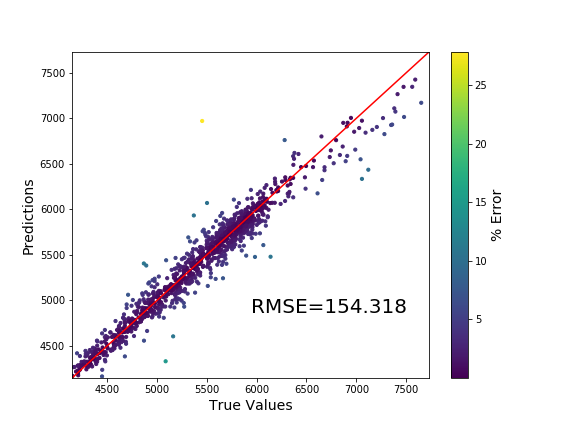

### Log g Prediction (color only)
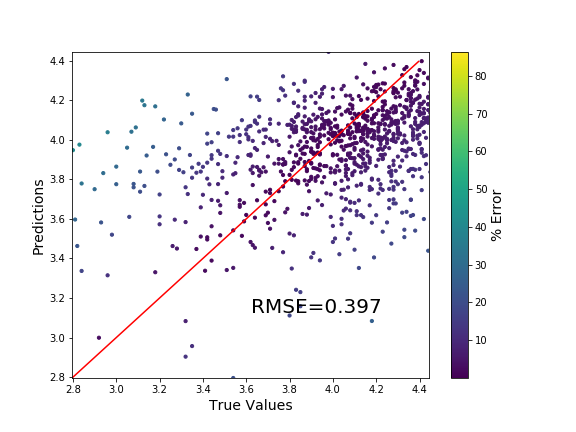

### Metallicity Prediction (color only)
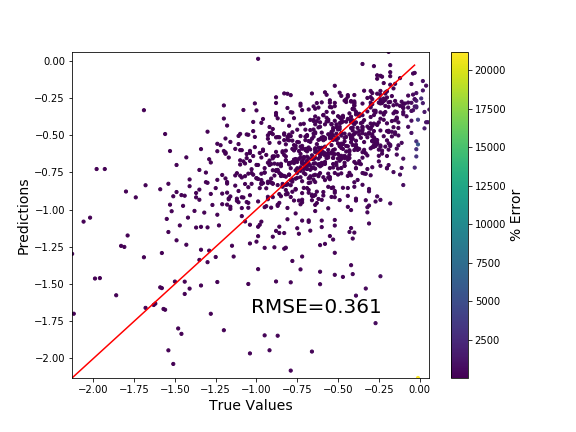

# Predicting the parameters together

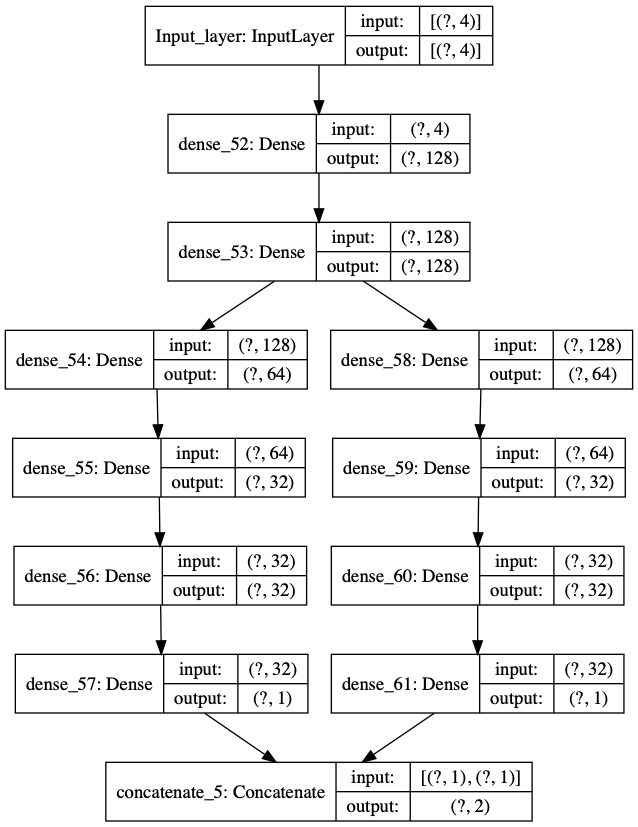

# $\rm T_{eff}$

<img src="./Combined_pred_Teff.png" width="400">

# $\rm log\ g$

<img src="./Combined_pred_logg.png" width="400">

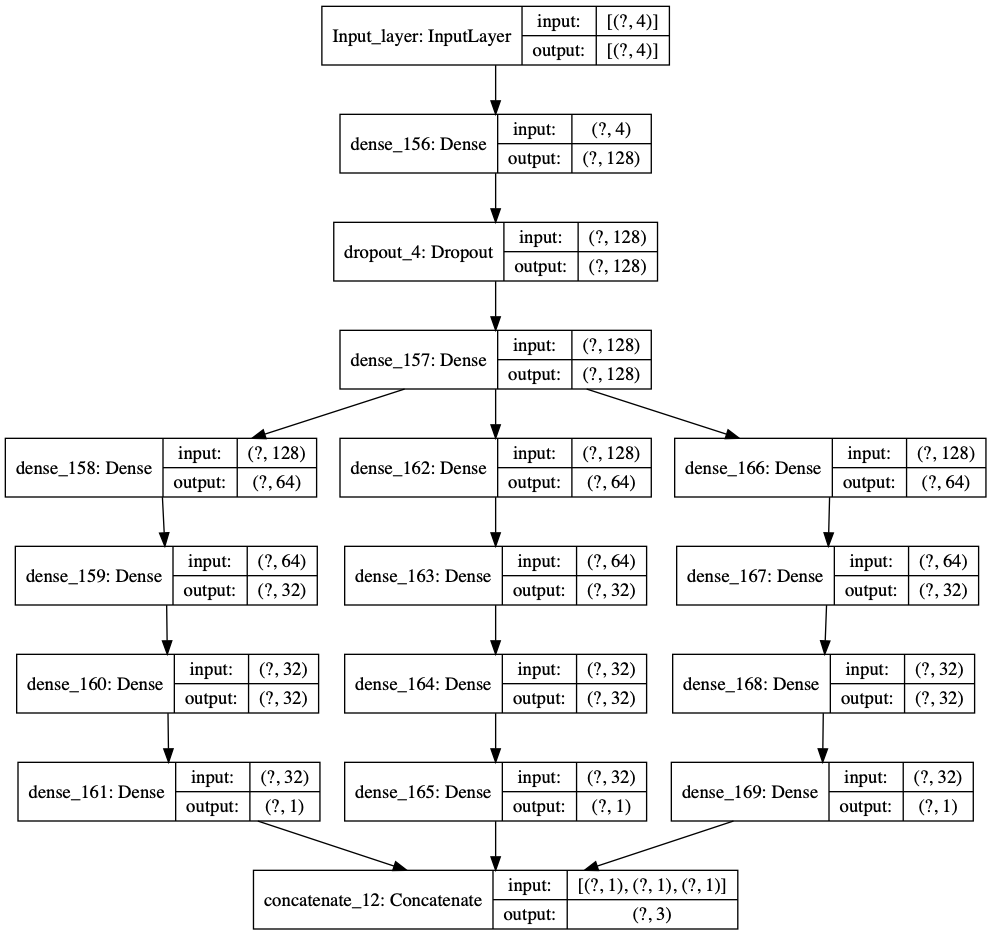

# $\rm T_{eff}$

<img src="./Combined_pred_all3_Teff.png" width="400">

# Log g

<img src="./Combined_pred_all3_logg.png" width="400">

# Metallicity

<img src="./Combined_pred_all3_Z.png" width="400">

# All Light Curve Features

### $T_{eff}$ Prediction (LC only)
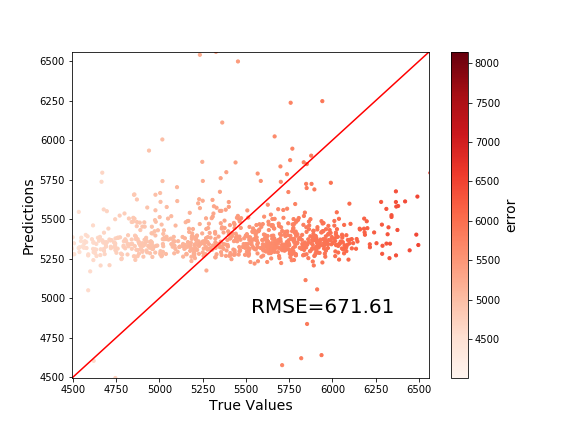

### Log g Prediction (LC only)
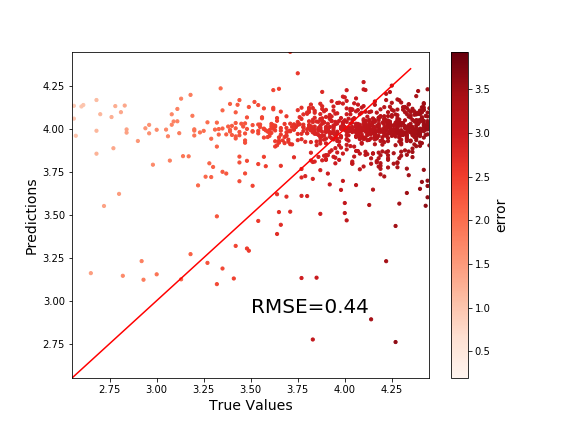

### Metallicity Prediction (LC only)
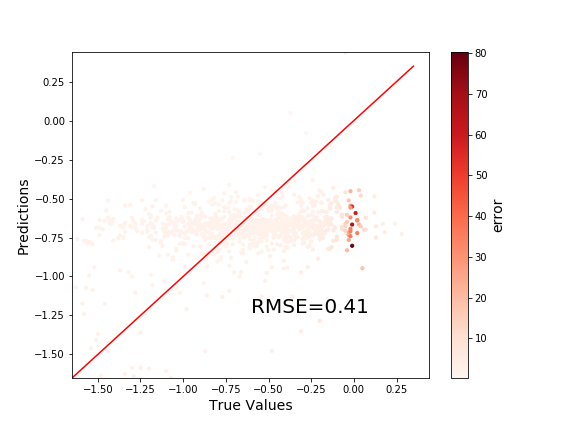

# Colors & All LC Features

### $T_{eff}$ Prediction (colors & LC)
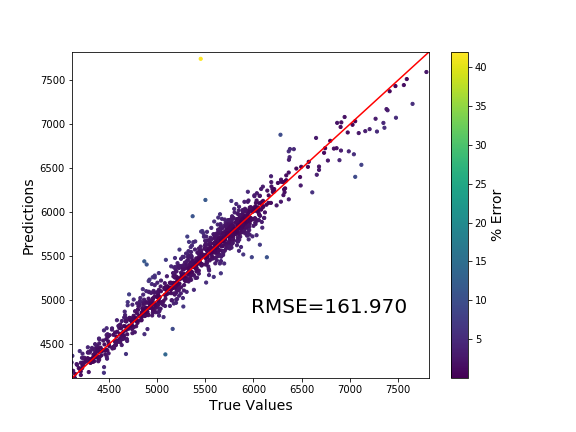

### Log g Prediction (colors & LC)
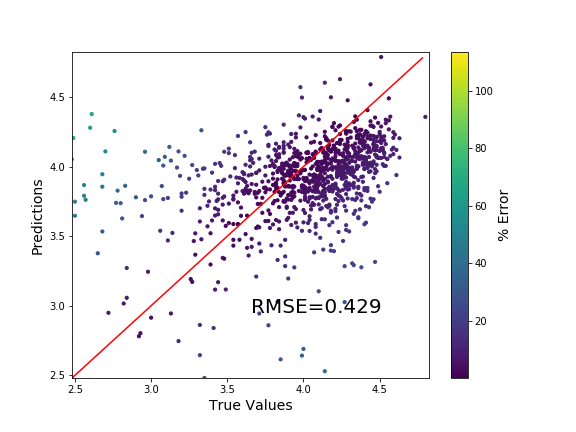

### Metallicity Prediction (colors & LC)
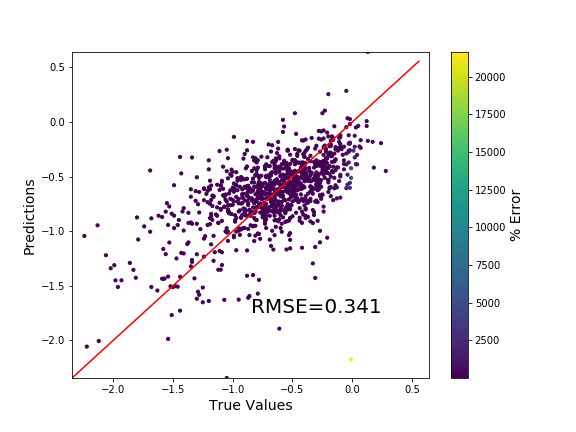

# RMSE Comparison

<img src="./Comparison_table_v2.png">

# Feature Importance

Code: 

perm = PermutationImportance(model_temp, scoring="r2",random_state=1).fit(normed_train_data, train_y)
eli5.show_weights(perm, feature_names = normed_train_data.columns.tolist())

<img src="./feature_importance.png">

# Conclusion  ? add anything?

### LSST

### Other NN Applications